In [2]:
import numpy as np
from matplotlib import pyplot as plt
from util import thresholding_algo
import lumicks.pylake as lk

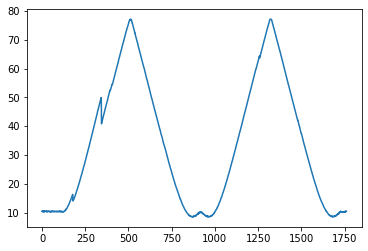

In [3]:
curves = lk.File("Data/TrmD_Marker25.h5")
plt.plot(curves.downsampled_force1.data)

array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 180])

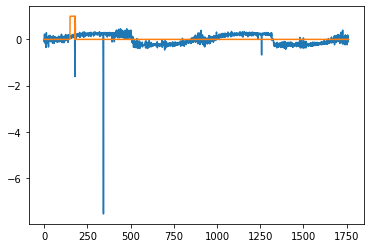

In [4]:
from util import average_around
def get_peak_indices(f):
    deltas = np.diff(f)
    plt.plot(deltas)
    peaksign = thresholding_algo(f, 150, 4.5, 0)
    plt.plot(peaksign["signals"])
    return np.arange(len(f))[peaksign["signals"] >= 1]

get_peak_indices(curves.downsampled_force1.data)

In [5]:
def find_transitions(y: np.ndarray, noise_estimation_window: tuple = None):
    EPS = 1e-4  # SNR stabilization factor 
    
    # Magic numbers
    SNR_SCALE_FACTOR = 10
    MIN_OUTLIER_FACTOR = 1.5
    MAX_OUTLIER_FACTOR = 4.5
    MIN_PERCENTILE = 10
    
    # Get noise estimation window
    if noise_estimation_window is None:
        end_slice = max(int(len(y)/10), 3)
        s = slice(0, end_slice)
    else:
        s = slice(**noise_estimation_window)
        
    # Calculate outlier threshold
    snr = (y.max() - y.min()) / (y[s].std() + EPS)
    outlier_factor = min(max(snr/SNR_SCALE_FACTOR, MIN_OUTLIER_FACTOR), MAX_OUTLIER_FACTOR)
    
    # Find outliers that deviate below the threshold (since force transitions are always negative in slope)
    dy = np.diff(y)
    low_percentile = np.nanpercentile(dy, MIN_PERCENTILE)
    median_low_diff = np.nanmedian(dy) - low_percentile
    outlier_threshold = low_percentile - outlier_factor * median_low_diff
    
    return np.where(dy < outlier_threshold)[0], outlier_threshold
    

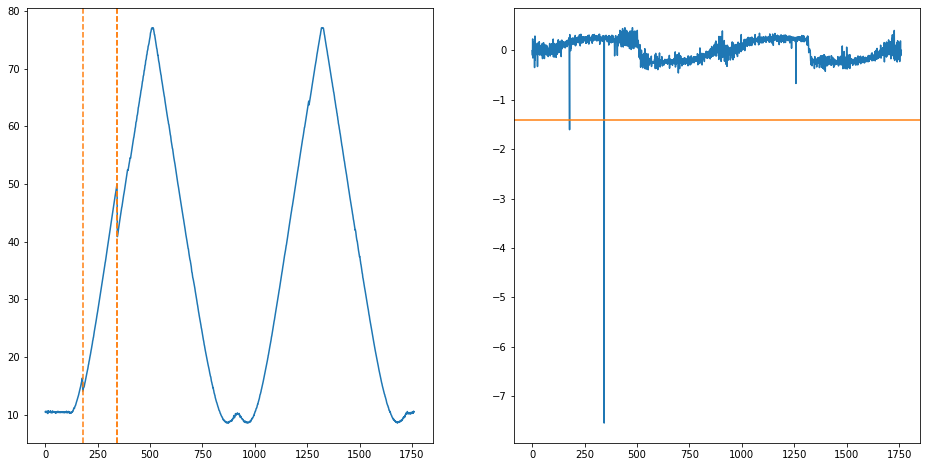

array([178, 342, 343])

In [6]:
# Plot simulated curve with transitions as orange lines
y = curves.downsampled_force1.data
x = np.arange(len(y))
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(x, y)
transition_idxs, outlier_threshold = find_transitions(y)
for idx in transition_idxs:
    plt.axvline(x=idx, c="tab:orange", linestyle="--")
    
# Plot diff of curve with threshold value indicated as orange line
plt.subplot(1,2,2)
plt.plot(np.diff(y))
plt.axhline(y=outlier_threshold, c="tab:orange")
plt.show()
transition_idxs


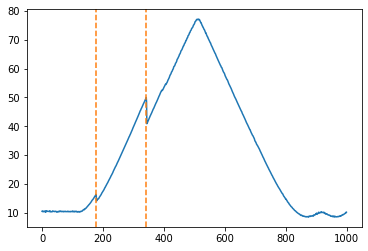

In [7]:
plt.plot(x[:1000],y[:1000])
for idx in transition_idxs[:-1]:
    plt.axvline(x=idx, c="tab:orange", linestyle="--")

In [8]:
from build_model import build_model
handlemodel = build_model("handles", ["inv_odijk", "force_offset"])
compmodel = (build_model("handles", ["odijk"])
            + build_model("protein", ["inv_marko_siggia_simple"])\
            ).invert(interpolate = True,
                     independent_min=0,
                     independent_max=90) + lk.force_offset("handles")


No handles with labels found to put in legend.


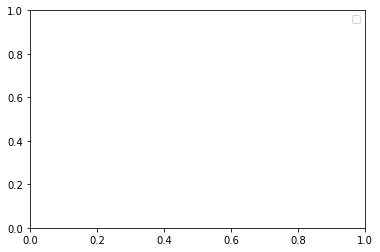

In [9]:
fit = lk.FdFit(handlemodel,compmodel)
f = curves.downsampled_force1.data[:transition_idxs[0]]
d = curves.distance1.data[:transition_idxs[0]]
fit[compmodel].add_data("first pull", f, d)
fit["handles/Lc"].value = .35
fit["handles/Lp"].value = 15
fit["handles/St"].value = 300
fit["handles/St"].lower_bound = 250
fit["handles/f_offset"].value = 0
fit["handles/f_offset"].upper_bound = 6
fit["handles/f_offset"].lower_bound = -6
fit.fit()
fit[handlemodel].plot()

In [49]:
fdc = lk.File('Data/adk5_curve1.h5').fdcurves['adk5_curve1']

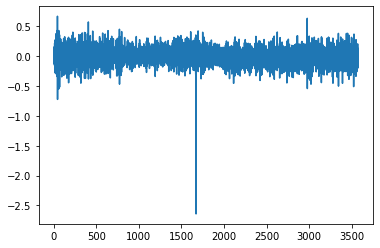

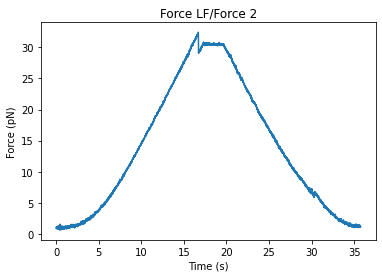

In [50]:
plt.plot(np.diff(fdc.f.data))
plt.figure()
fdc.f.plot()

0.7084966679641023
0.6053910736927715


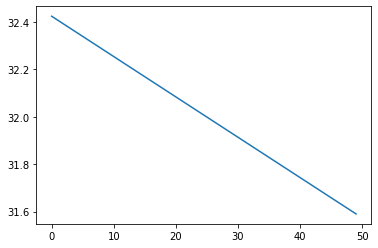

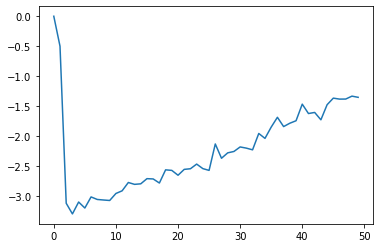

In [51]:
f = fdc.f.data
STEP_SIZE = 50
max_index = np.argmax(f)
n = len(f)
rightleast = max_index
rightmost = max_index + STEP_SIZE
window = f[rightleast:rightmost]
x = np.arange(len(window))
slope = -1 * f[rightleast] / (n - rightleast)
line = x * slope + f[rightleast]
plt.plot(line)
plt.figure()
plt.plot(window - line)
print(np.std(window - line))
print(np.std(window))

In [67]:
len(f)

3577

In [102]:
def get_first_trough_index(f, last=False):
    stds = []
    for i in range(25, len(f) - 25):
        std = average_around(f, i, half_n=25)["std"]
        if last:
            stds.insert(0, std)
        else:
            stds.append(std)          

    div = 4
    peaksign = thresholding_algo(stds,int(len(f) / div),4.,0)["signals"]
    while min(peaksign) > -1:
        div = div + 1
        peaksign = thresholding_algo(stds,int(len(f) / div),4.,0)["signals"]
    print(div)
    if last:
        return len(f) - np.arange(25, len(stds) + 25)[peaksign <= -1][0]
    return np.arange(25, len(stds) + 25)[peaksign <= -1][0]


6
6
4


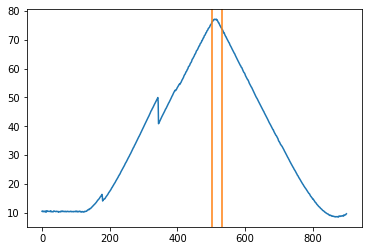

In [103]:
yn = y[0:900]
get_first_trough_index(yn)
plt.plot(yn)
plt.axvline(x=get_first_trough_index(yn), c='tab:orange')
plt.axvline(x=get_first_trough_index(yn,True), c='tab:orange')

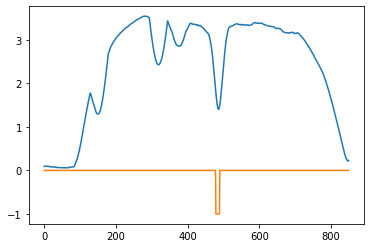

In [104]:
stds = []
for i in range(25,len(yn) - 25):
    stds.append(average_around(yn, i, half_n=25)["std"])
plt.plot(stds)
peaksign = thresholding_algo(stds,300,4,0)["signals"]
plt.plot(peaksign)